In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [3]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [4]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express



In [5]:

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'D', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [-15, -13],
               [-6, -4],
               [1, 1000]]
}

problem2 = {
    'num_vars': 4,
    'names': ['kon', 'k2', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [1e-6, 1e-1],
               [1, 1000]]
}


vals = SALib.sample.sobol.sample(problem1, 65536)
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []
indicies_1 = []
indicies_2 = []
indicies_3= []
indicies_4 = []
indicies_5 = []

In [6]:
65536

65536

In [7]:
sol_holder = []
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
     
        rtot = params[0]
        rtot  = 10**rtot
        kon = params[1]
        kon = 10**kon
        D = params[2]
        D = 10**D
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        k2 = 4*D/tumour_cell_surface_area

        guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag =(A1_st + A2_st)
        Y[i] = Ag
        Y1[i] = Ag/rtot
        Y2[i] = (A1_st + 2*A2_st)/rtot
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])
    Si = sobol.analyze(problem1, Y1, print_to_console=True)
    indicies_2.append(Si['ST'])
    indicies_3.append(Si['S1'])
    Si = sobol.analyze(problem1, Y2, print_to_console=True)
    indicies_4.append(Si['ST'])
    indicies_5.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.857458  0.077591
kon    0.342006  0.036170
D      0.341787  0.034381
koff   0.646519  0.063813
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.131545  0.026982
kon    0.015579  0.007635
D      0.013043  0.005830
koff   0.047020  0.018254
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.086186  0.053190
(rtot, D)      0.087287  0.057249
(rtot, koff)   0.250232  0.068800
(rtot, dummy)  0.008216  0.042933
(kon, D)       0.002364  0.012616
(kon, koff)    0.026651  0.022690
(kon, dummy)  -0.006841  0.010399
(D, koff)      0.028547  0.021399
(D, dummy)    -0.001907  0.008444
(koff, dummy) -0.001579  0.023100
             ST   ST_conf
rtot   0.999669  0.007560
kon    0.001075  0.000128
D      0.001065  0.000116
koff   0.002103  0.000223
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.997174  0.011946
kon    0.000028  0.000340
D      0.000057  0.000346
koff   0.000134  0.000460
dummy  0.000000  0.000

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999985  7.975637e-03
kon    0.000013  4.356630e-07
D      0.000009  2.949387e-07
koff   0.000004  3.356052e-07
dummy  0.000000  0.000000e+00
                 S1   S1_conf
rtot   9.999746e-01  0.012942
kon    5.836009e-06  0.000037
D      2.604942e-07  0.000031
koff  -1.667298e-06  0.000021
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)   -1.887099e-06  0.018709
(rtot, D)     -2.581849e-06  0.018715
(rtot, koff)  -1.777399e-07  0.018710
(rtot, dummy) -3.479432e-06  0.018711
(kon, D)       8.781666e-07  0.000053
(kon, koff)   -1.538846e-06  0.000053
(kon, dummy)  -1.856258e-06  0.000053
(D, koff)      4.280008e-06  0.000040
(D, dummy)     3.948302e-06  0.000040
(koff, dummy)  1.995384e-05  0.000033
             ST   ST_conf
rtot   0.622533  0.013870
kon    0.377018  0.011460
D      0.281752  0.007989
koff   0.020405  0.001171
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.435615  0.018586
kon    0.18020

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.998082e-01  7.368411e-03
kon    1.625088e-04  4.626510e-06
D      1.575485e-04  4.717277e-06
koff   1.040688e-07  5.017212e-09
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.997258e-01  0.010966
kon    8.172250e-05  0.000136
D      7.907153e-05  0.000143
koff   1.728141e-07  0.000004
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    3.637772e-05  0.015954
(rtot, D)      3.430056e-05  0.015976
(rtot, koff)   6.966573e-07  0.015973
(rtot, dummy)  7.827342e-07  0.015974
(kon, D)       3.312036e-05  0.000206
(kon, koff)    1.708322e-06  0.000205
(kon, dummy)   1.695572e-06  0.000205
(D, koff)      2.516363e-07  0.000218
(D, dummy)     2.458677e-07  0.000218
(koff, dummy) -4.649586e-08  0.000005
             ST   ST_conf
rtot   0.437847  0.010456
kon    0.444756  0.011112
D      0.430217  0.009743
koff   0.000309  0.000017
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.238194 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.984258e-01  7.218130e-03
kon    1.387341e-03  4.184492e-05
D      1.383167e-03  3.999061e-05
koff   9.461411e-09  4.633154e-10
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.975935e-01  1.222739e-02
kon    6.752792e-04  4.302807e-04
D      6.751552e-04  3.961443e-04
koff   4.448782e-08  9.824497e-07
dummy  0.000000e+00  0.000000e+00
                         S2   S2_conf
(rtot, kon)    3.541366e-04  0.019684
(rtot, D)      3.514110e-04  0.019864
(rtot, koff)   3.679806e-06  0.019658
(rtot, dummy)  3.704929e-06  0.019658
(kon, D)       2.303999e-04  0.000651
(kon, koff)    5.139699e-06  0.000649
(kon, dummy)   5.139860e-06  0.000649
(D, koff)      3.268643e-07  0.000689
(D, dummy)     3.325108e-07  0.000689
(koff, dummy) -1.180230e-08  0.000002
             ST       ST_conf
rtot   0.409245  7.902853e-03
kon    0.410166  7.940887e-03
D      0.408348  8.038381e-03
koff   0.000005  2.457536e-07
dummy  0.000000  0.00000

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.917204e-01  7.925329e-03
kon    8.058636e-03  1.920312e-04
D      8.057352e-03  2.103719e-04
koff   8.220031e-10  4.330793e-11
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.855994e-01  1.271616e-02
kon    3.716042e-03  8.585836e-04
D      3.723513e-03  9.180882e-04
koff   1.201922e-08  3.118674e-07
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    2.642983e-03  1.883877e-02
(rtot, D)      2.641433e-03  1.863234e-02
(rtot, koff)   9.842230e-06  1.858779e-02
(rtot, dummy)  9.847088e-06  1.858785e-02
(kon, D)       8.547637e-04  1.551004e-03
(kon, koff)    1.457578e-05  1.484290e-03
(kon, dummy)   1.457619e-05  1.484289e-03
(D, koff)      1.005857e-06  1.541006e-03
(D, dummy)     1.009002e-06  1.541014e-03
(koff, dummy) -2.905951e-09  4.302669e-07
                 ST       ST_conf
rtot   3.704036e-01  5.240344e-03
kon    3.705679e-01  4.773668e-03
D      3.702797e-01  5.60375

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.803093e-01  7.878098e-03
kon    2.203010e-02  4.899133e-04
D      2.203460e-02  5.739223e-04
koff   5.797693e-11  3.123164e-12
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.584122e-01  1.091636e-02
kon    9.447868e-03  1.740597e-03
D      9.472014e-03  1.542084e-03
koff   2.905454e-09  7.661695e-08
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    1.011899e-02  1.821166e-02
(rtot, D)      1.011625e-02  1.890685e-02
(rtot, koff)   1.259929e-05  1.834999e-02
(rtot, dummy)  1.260066e-05  1.834999e-02
(kon, D)       7.873786e-04  2.903098e-03
(kon, koff)    3.540975e-05  2.797967e-03
(kon, dummy)   3.541006e-05  2.797966e-03
(D, koff)     -5.069038e-06  2.833934e-03
(D, dummy)    -5.069120e-06  2.833932e-03
(koff, dummy) -1.395683e-11  1.305612e-07
                 ST       ST_conf
rtot   3.510711e-01  3.831706e-03
kon    3.510973e-01  3.611751e-03
D      3.510444e-01  3.69658

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_661/1297055009.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


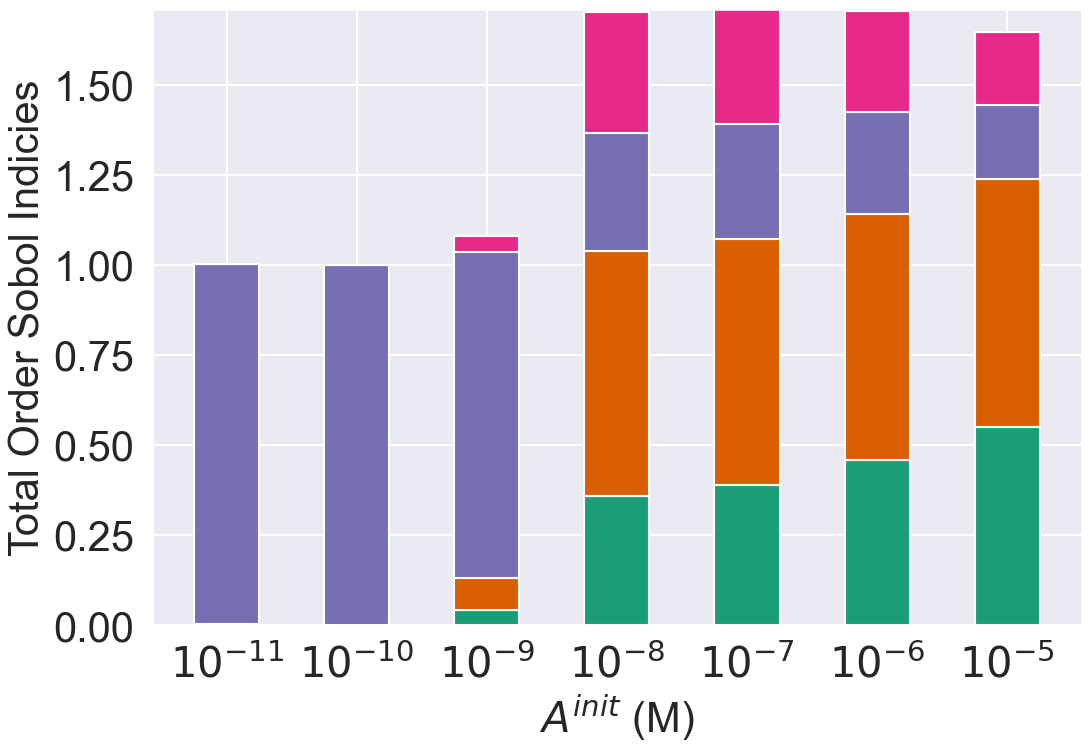

In [30]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies_4[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, D_si, width, label=r'$D$', bottom= bottom, color=cm(3))
bottom+= D_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
#ax.legend(loc='best', fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('Total Order Sobol Indicies', fontsize=30)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_receptor_occupancy_total_order_sensiv_analysis.png')

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_661/668093037.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


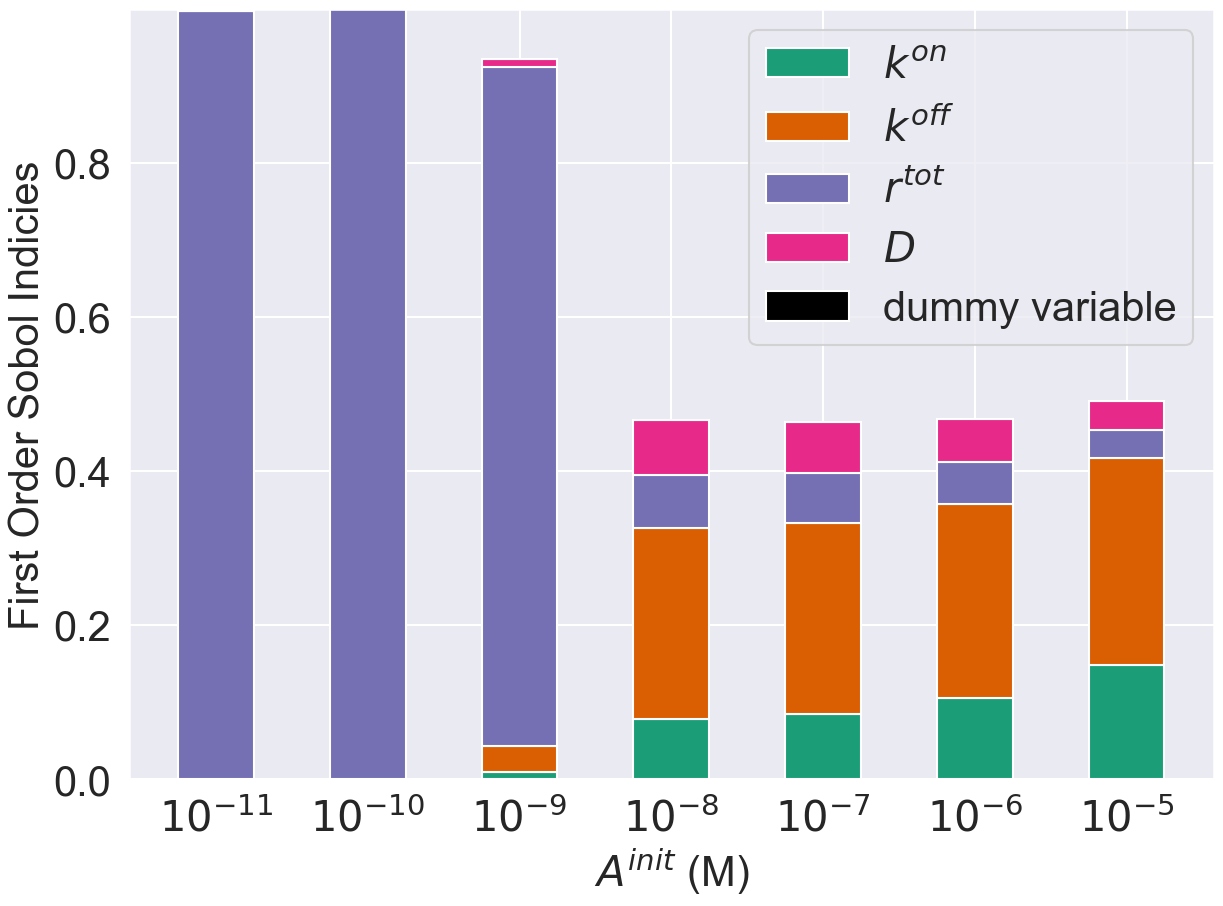

In [31]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies_5)):
    vals = indicies_5[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(14,10))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, D_si, width, label=r'$D$', bottom= bottom, color=cm(3))
bottom+= D_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('First Order Sobol Indicies', fontsize=30)
ax.tick_params(labelsize=30)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_receptor_occupancy_first_order_sensiv_analysis.png')